# GOEMod: Groundwater outcrop and erosion model

A simple model of groundwater flow, overland flow and erosion in 2D, with parallel streams.

Named after the groundwater outcrop erosion model, as first conceptualized by de Vries (1974, 1976)


## import modules:

In [40]:
import imp
import itertools
import string
import datetime
import inspect
import time
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.gridspec import GridSpec

import pandas as pd

# import gw and erosion functions
#from lib.gw_erosion_lib import *
import lib.gw_erosion_lib as gwe

import lib.figure_lib as flib

pl.rcParams['mathtext.default'] = 'regular'

## Name of model run

In [41]:
model_run_name = 'base_case'

## Some fixed values

In [42]:
hour = 60.0 * 60.0
day = 24.0 * hour
year = 365.25 * day
kyr = 1e3 * year

## Set up model parameters

In [43]:
class ModelParams:
    
    hour = 60.0 * 60.0
    day = 24.0 * hour
    year = 365.25 * day
    kyr = 1e3 * year

    # timestep
    dt = 1.0 * year

    #n_timesteps = 1000
    total_runtime = 1e5 * year

    # dimensions of model domain in x direction, perpendicular to streams
    width = 10000

    #
    dx = 5.0

    #
    fixed_upstream_length = True

    # upstream length: length of contributing area to streams, upstream from the modeled 2D cross section
    upstream_length = width / 2.0
    
    # downstream length: length to downstream boundary with fixed elevation
    # used to calculate stream slope if recalculate_slope = True
    downstream_length = width / 2.0

    # initial relief
    initial_relief = 0.5
    n_initial_topo_segments = 200
    
    # Use initial topography from file instead of generating random topography
    use_relief_from_file = False
    
    # name of file with topography data. this should be a file with two columns named x and z
    relief_file = 'default_topography.csv'
    
    # save the generated topography to a new file
    generate_relief_file = False

    #
    #max_z_change_limit = 0.1

    # aspect ratio to calculate size of each sub-catchment in the 3rd dimension
    # aspect ratio of 2.0 means that the upstream contributing length 
    # is 2x the length of the contributing area
    # in the model domain / cross-section
    upstream_aspect_ratio = 1.0

    # precipitation (=precip - evapotranspiration)
    P = 0.75 / year

    #
    precip_return_time = 1.0 * year
    
    #
    infiltration_capacity = 1.0e-4
    
    # evapotranspiration
    ET = 0.375 / year

    # overland flow vs recharge parameters
    phi = 0.20
    specific_yield = 0.20

    # average recharge or calculate spatially distributed values
    average_rch = False

    # transmissivity (m2/sec)
    T = 10**-3

    # erosion parameters:
    #rho_s = 2650.0

    # Erosion parameters in Tucker et al. (1998) and Boogaart et al. (2002, Geomorphology)
    # note the k_f value in Boogaart et al. is somewhat suspect, i failed to reproduce the values from the equations
    # given in this paper. Using the value for k_f from Tucker et al. (1998) instead.
    k_f = 0.316
    m = 1.8
    n = 2.1
    
    # hillslope diffusion coefficient
    K_d = 10**-2.0 / year

    # Manning coefficient
    # 20-30 in de Vries (1995)
    K_n = 25.0

    # channel slope
    S_init = S = 5.0e-3
    
    # recalculate channel slope using a steady baselevel at z = slope_init * downstream_length
    recalculate_slope = True

    # parameters relating channel width and discharge, based on compilation by van den Berg (1995)
    k_w = 3.65
    omega = 0.5

    # slope of stream bed perpendicular to flow direction
    St = 0.05
    
    # variable timestepping
    variable_dt = True
    
    # maximum timestep
    max_dt = 1000 * year
    
    # maximum relative relief change in one timestep. expressed as fraction of total relief
    max_rel_dz = 0.005

    # minimum relative relief change in one timestep
    min_rel_dz = 0.001

    # minimum absolte change in relief in on timestep
    min_abs_dz = 0.001

    #
    init_z = 0.0

    # duration single precipitation events
    hour = 3600.
    day = 24 * hour
    precipitation_duration = 3.0 * hour

## Some figure parameters

In [55]:
xlabel = 'Distance (m)'
ylabel = 'Elevation (m)'

cmap = pl.get_cmap('tab20')

land_surf_color = cmap(10.0 * 1/20.)
watertable_color = cmap(0.0 * 1/20.)

col_overland = cmap(18.0 * 1/20.)
col_baseflow = cmap(8.0 * 1/20.)
col_hillslope = cmap(3.0 * 1/20.)

past_surf_color = cmap(11.0 * 1/20.)
past_wt_color = cmap(1.0 * 1/20.)
init_surf_color = cmap(11.0 * 1/20.)
init_wt_color = cmap(1.0 * 1/20.)
    

## Generate an id number for this particular model run

This is useful to keep track of output datasets and figures

In [45]:
model_id = int(np.random.rand(1) * 1000)

today = datetime.datetime.now()
today_str = '%i-%i-%i' % (today.day, today.month, today.year)

output_file_adj = '%s_id_%i_%s' % (model_run_name, model_id, today_str)

print('appending this to each figure and output dataset filename: ', output_file_adj)

appending this to each figure and output dataset filename:  base_case_id_456_6-4-2021


## Run the model

In [46]:
imp.reload(gwe)

mp = ModelParams

# run the model once
start_time = time.time()
model_results = gwe.model_gwflow_and_erosion(
    mp.width, mp.dx, 
    mp.total_runtime, mp.dt, 
    mp.min_rel_dz, mp.max_rel_dz, mp.min_abs_dz,
    mp.fixed_upstream_length, mp.upstream_length, mp.upstream_aspect_ratio,
    mp.downstream_length,
    mp.P, mp.precipitation_duration, mp.precip_return_time, 
    mp.infiltration_capacity, mp.ET, 
    mp.initial_relief, mp.n_initial_topo_segments, mp.init_z,
    mp.T, mp.specific_yield, mp.phi,
    mp.S_init, mp.St, 
    mp.k_f, mp.K_n, mp.n, mp.m, mp.k_w, mp.omega, mp.K_d, mp.recalculate_slope,
    variable_dt=mp.variable_dt, max_dt=mp.max_dt,
    max_CFL_number=0.5, explicit_diffusion_solver=True, 
    use_relief_from_file=mp.use_relief_from_file, relief_file=mp.relief_file, 
    generate_relief_file=mp.generate_relief_file)

duration = time.time() - start_time
print('this model run took %0.0f seconds' % duration)

# copy model results
(times, x, zs, hs, dzs, Q_baseflows, Q_overland_flows, n_str_of, 
 erosion_of_per_yr, erosion_bf_per_yr, erosion_hd_per_yr,
 Q_baseflow_nodes, Q_overland_flow_nodes) = model_results

generating initial topography with max relief of 0.50 m and 200 linear segments
including first 9 3 hr precipitation events to arrive at total P of 0.74 m / yr with a target of 0.75 m/yr
max infiltration depth = 1.08
starting model runs
timestep 0, time = 0.0 yrs of 100000 yrs, active streams = 0, min z = -0.25
timestep 1, time = 4.7 yrs of 100000 yrs, active streams = 45, min z = -0.25
timestep 2, time = 6.3 yrs of 100000 yrs, active streams = 68, min z = -0.25


/Users/elcopone/werk/python_scripts/goemod/lib/gw_erosion_lib.py:596: RuntimeWarning: divide by zero encountered in double_scalars
  b = ((V0 * St) / L) ** (-1./3.)
/Users/elcopone/werk/python_scripts/goemod/lib/gw_erosion_lib.py:1240: RuntimeWarning: invalid value encountered in true_divide
  dz_of_event = -2.0 * V_erosion_of_rock / (upstream_length_of * channel_width_of)
/Users/elcopone/werk/python_scripts/goemod/lib/gw_erosion_lib.py:492: RuntimeWarning: divide by zero encountered in true_divide
  xi = (z[:-1] - he[:-1]) / (he_slope - z_slope)


timestep 3, time = 8.2 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 4, time = 10.0 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 5, time = 11.8 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 6, time = 13.6 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 7, time = 15.5 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 8, time = 17.4 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 9, time = 19.2 yrs of 100000 yrs, active streams = 67, min z = -0.25
timestep 10, time = 21.1 yrs of 100000 yrs, active streams = 67, min z = -0.26
timestep 11, time = 23.0 yrs of 100000 yrs, active streams = 67, min z = -0.26
timestep 12, time = 24.9 yrs of 100000 yrs, active streams = 67, min z = -0.26
timestep 13, time = 26.8 yrs of 100000 yrs, active streams = 67, min z = -0.26
timestep 14, time = 28.7 yrs of 100000 yrs, active streams = 67, min z = -0.26
timestep 15, time = 30.6 yrs of 100000 yrs, active streams =

## Make a figure of the default model run:

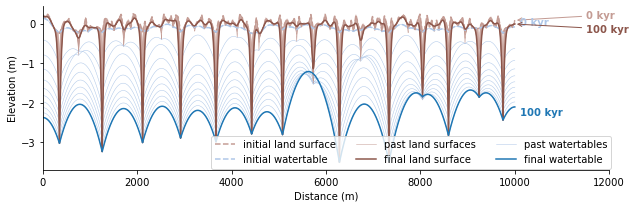

In [47]:
imp.reload(flib)

######
fig, ax = pl.subplots(1, 1, figsize=(9, 3))

ax.set_aspect('auto')

flib.make_h_and_z_plot(ax, times, x, zs, hs, leg_position=(0.65, 0.24))

fig.tight_layout()

fig.savefig('model_results/modelled_surface_and_watertable_%s.pdf' % output_file_adj)

## Make a figure of the water & erosion fluxes over time

saving figure as model_results/overview_variables_vs_time_default_run_base_case_id_456_6-4-2021.pdf


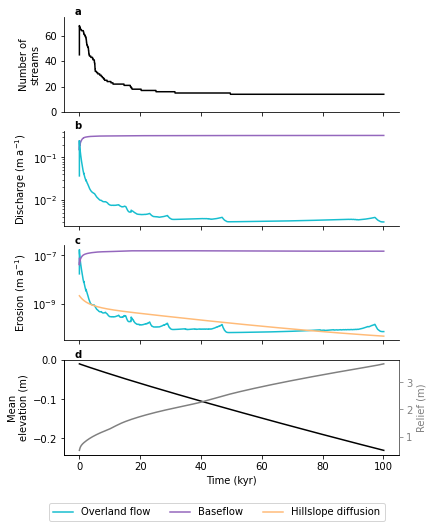

In [48]:
# copy model results
#(times, x, zs, hs, dzs, Q_baseflows, Q_overland_flows, n_str_of, 
# erosion_of_per_yr, erosion_bf_per_yr, erosion_hd_per_yr,
# Q_baseflow_nodes, Q_overland_flow_nodes) = model_results

fig, axs = pl.subplots(4, 1, figsize=(6, 8), sharex=True)
flib.vars_over_time_fig(axs, times, mp.width, n_str_of, 
                        Q_baseflows, Q_overland_flows, 
                        erosion_of_per_yr, erosion_bf_per_yr,
                        erosion_hd_per_yr, zs, 
                        add_legend=True, add_labels_left=True, 
                        add_labels_right=True)

for i, panel in enumerate(axs.ravel()):
    panel.spines['top'].set_visible(False)
    #panel.spines['right'].set_visible(False)
    panel.text(0.03, 1.0, string.ascii_lowercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='bottom')

fn = 'model_results/overview_variables_vs_time_default_run_%s.pdf' % output_file_adj

print('saving figure as %s' % fn)
fig.savefig(fn)

## Make a figure of fluxes, elevation, watertable at three timeslices

selected timeslices to show:  [1763, 1813, 1863]
saving model exps as model_results/modelled_h_and_z_timeslices_groundwater_capture_base_case_id_456_6-4-2021.pdf


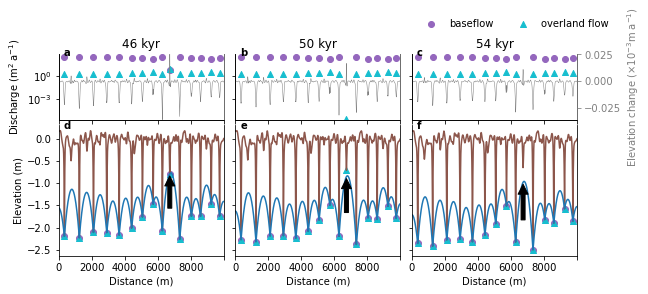

In [49]:
#surface_col = 'brown'
#wt_col = 'blue'

cmap = pl.get_cmap('tab20')

surface_col = cmap(10.0 * 1/20.)
wt_col = cmap(0.0 * 1/20.)

# show last groundwater capture event
show_gw_capture = True

# timesteps to before and after capture event
ts_buffer = 50

if show_gw_capture is False:
    # select timeslices: three evenly distributed timeslices
    nplots = 3
    n_times = len(zs)
    plot_times = np.linspace(times[0], times[-1], nplots + 1)[1:]
    output_timeslices = np.array([np.argmin(np.abs(p - times)) for p in plot_times])

else:
    # alternative: pick three timeslices just before, at and after groundwater capture event
    nplots = 3
    ts_stream_capt = np.where(np.diff(n_str_of) != 0)[0][-1]
    output_timeslices = [ts_stream_capt-ts_buffer, ts_stream_capt, ts_stream_capt+ts_buffer]
    
    st1 = np.sign(Q_overland_flow_nodes[ts_stream_capt-1])
    st2 = np.sign(Q_overland_flow_nodes[ts_stream_capt+1])             
    
    x_ind_stream_capt = np.where(st2 != st1)[0][0]
    x_stream_capt = x[x_ind_stream_capt]
    

if output_timeslices[-1] > (len(times) -1):
    output_timeslices[-1] = len(times) - 1
print('selected timeslices to show: ', output_timeslices)

nrows = 2
ncols = nplots

fig, axs = pl.subplots(nrows, ncols, figsize=(nplots * 3, 4),
                       sharex='col', sharey='row',
                       gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05, 'wspace': 0.07})
axs = axs.ravel()

taxs = [axs[i] for i in range(nplots)]
baxs = [axs[nplots + i] for i in range(nplots)]

raxs = [ax.twinx() for ax in taxs]

# get min max values of fluxes
qs_comb = np.vstack([Q_baseflow_nodes[output_timeslices], 
                          Q_overland_flow_nodes[output_timeslices]])
ind = qs_comb > 0
qmins = np.min(qs_comb[ind])
qmaxs = np.max(qs_comb[ind])

#
for ts, tax, rax, bax in zip(output_timeslices, taxs, raxs, baxs):

    # surface and wataertable
    bax.plot(x, zs[ts], color=surface_col)
    bax.plot(x, hs[ts], color=wt_col)

    # erosion
    rax.plot(x, dzs[ts] * 1e3, color='gray', lw=0.5, zorder=1)
    rax.set_ylim(dzs[output_timeslices].min() * 1e3, dzs[output_timeslices].max() * 1e3)

    # fluxes
    tax.set_yscale('log')

    ind = Q_baseflow_nodes[ts] > 0
    l_bf = tax.scatter(x[ind], Q_baseflow_nodes[ts][ind] * year,
                       marker='o', color=col_baseflow, zorder=2)
    bax.scatter(x[ind], zs[ts][ind], marker='o', color=col_baseflow)#, facecolor='None')

    ind = Q_overland_flow_nodes[ts] > 0
    l_of = tax.scatter(x[ind], Q_overland_flow_nodes[ts][ind] * year, marker='^', 
                       color=col_overland, zorder=2)
    bax.scatter(x[ind], zs[ts][ind], marker='^', color=col_overland)#, facecolor='None')

    if tax == taxs[-1]:
        labels = ['baseflow', 'overland flow']
        tax.legend([l_bf, l_of], labels, 
                   frameon=False, ncol=2, 
                   bbox_to_anchor=[0.0, 1.25], loc='lower left')
        
    # add arrow for captured stream
    import matplotlib.patches as mpatches
    
    x_tail = x_head = x_stream_capt
    yl = (zs[ts].max() - zs[ts].min()) / 3.0
    y_head = hs[ts][x_ind_stream_capt]
    y_tail = y_head - yl
    dx = x_head - x_tail
    dy = y_head - y_tail
    
    arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                     mutation_scale=20, color='black', zorder=101)
    bax.add_patch(arrow)
 
    tax.set_ylim(qmins * year * 0.75, qmaxs * year * 2.0)

    bax.set_xlim(x.min(), x.max())

    tax.set_title('%0.0f kyr' % (times[ts] / kyr))

#labels = ['baseflow', 'overland flow']
#fig.legend([l_bf, l_of], labels, frameon=False, ncol=2, loc='lower center')

for ax in baxs:
    for label in ax.xaxis.get_ticklabels()[-1:]:
        label.set_visible(False)   


if nplots > 1:
    for rax in raxs[:-1]:
        rax.set_yticks([])
        rax.set_ylabel('')

for ax in baxs:
    ax.set_xlabel('Distance (m)')
    ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)

for tax, rax in zip(taxs, raxs):
    tax.spines['top'].set_visible(False)
    rax.spines['top'].set_visible(False)

for rax in raxs:
    rax.spines['right'].set_color('grey')
    rax.yaxis.label.set_color('grey')
    rax.tick_params(axis='y', colors='grey')

baxs[0].set_ylabel('Elevation (m)')
taxs[0].set_ylabel(r'Discharge ($m^2\;a^{-1}$)')
raxs[-1].set_ylabel(r'Elevation change ($\times 10^{-3} m\;a^{-1}$)')

for i, panel in enumerate(axs):
    #panel.spines['top'].set_visible(False)
    #panel.spines['right'].set_visible(False)
    panel.text(0.03, 0.95, string.ascii_lowercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='bottom')

if show_gw_capture is True: 
    fn = 'model_results/modelled_h_and_z_timeslices_groundwater_capture_%s.pdf' % output_file_adj
else:
    fn = 'model_results/modelled_h_and_z_3_timeslices_%s.pdf' % output_file_adj

#fig.tight_layout()

fig.subplots_adjust(top=0.82, left=0.1, bottom=0.12)

print('saving model exps as %s' % fn)
fig.savefig(fn)


## Make an animation

<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-68-b6e06df64b0d>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if video_fm is 'mpeg':


saving animation as model_results/model_animation_base_case_id_456_6-4-2021.gif
done


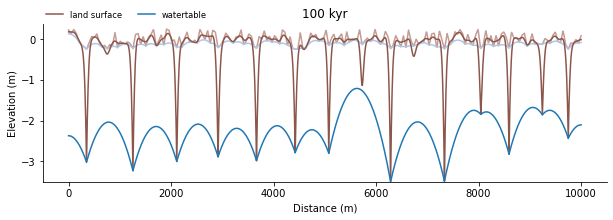

In [68]:
video_fm = 'gif'

wt_col = watertable_color
wt_col_alt = past_wt_color
surface_col = land_surf_color
surface_col_alt = past_surf_color

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

def init():
    lz.set_data([], [])
    lh.set_data([], [])
    return line,

def animate(i, ax, tp, x, zs, hs, lz, lh, title, zmax):
    
    lz.set_data(x, zs[i])
    lh.set_data(x, hs[i])
    
    title.set_text('%0.0f kyr' % (tp[i]))
    
    ax.set_ylim(zs[i].min(), zmax)
    
    return lz, lh,


n_frames = 100
plot_times = np.linspace(times[0], times[-1], n_frames)
plot_inds = np.array([np.argmin(np.abs(p - times)) for p in plot_times])


fig, ax = pl.subplots(1, 1, figsize=(9, 3))

fig.subplots_adjust(bottom=0.17, right=0.97, top=0.90, left=0.10)
#fig.tight_layout()

title = ax.set_title('%0.0f kyr' % (times[0] / kyr))

li, = ax.plot(x, zs[0], color=surface_col_alt)
li, = ax.plot(x, hs[0], color=wt_col_alt)
lz, = ax.plot(x, zs[0], color=surface_col, label='land surface')
lh, = ax.plot(x, hs[0], color=wt_col, label='watertable')

#ax.set_ylim(zs[0].max() * 1.1, zs[-1].min())

ax.legend(fontsize='small',loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=2,
            borderaxespad=0, frameon=False)

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#n_times = n_frames
#n_times = 10

zmax = zs[0].max() * 1.5

zsp = [zs[i] for i in plot_inds]
hsp = [hs[i] for i in plot_inds]
tp = [times[i]/kyr for i in plot_inds]

anim = FuncAnimation(fig, animate, n_frames, fargs=(ax, tp, x, zsp, hsp, lz, lh, title, zmax),
                     interval=200, blit=True)


if video_fm is 'mpeg':
    writer = animation.FFMpegWriter(fps=30)
    fn = 'model_results/model_animation_%s.mp4' % output_file_adj

else:
    fn = 'model_results/model_animation_%s.gif' % output_file_adj
    writer = 'pillow'

print('saving animation as %s' % fn)
anim.save(fn, writer="pillow", dpi=100)
print('done')
#anim.save(fn)